## Introduction to Polymer SMILES **(PSMILES)**: Formation and Tokenization of Polymer String Representation

### Table of Contents:
1. [Introduction](#intro)
  - [Setup and Imports](#intro1)
2. [PolymerSMILES (PSMILES)](#psmiles)
  - [Basic String Syntax](#psmiles1)
  - [Canonicalization Routine for PSMILES](#psmiles2)
    - [Importance of canonicalization of PSMILES](#psmiles21)
    - [Steps for Canonicalization](#psmiles22)

3. [Tokenization of PSMILES with SentencePiece](#token)
  - [Introduction to SentencePiece](#token1)
  - [Implementing SentencePiece](#token2)

4. [Applications and Limitations](#app)

5. [Summary](#sum)

6. [References](#ref)

### 1. Introduction <a id="intro"></a>

Polymer SMILES (PSMILES) `[2]` is an extension of the Simplified Molecular Input Line Entry System (SMILES)`[1]` notation, which is used to represent the structures of polymers. While traditional SMILES is designed to depict small organic molecules, PSMILES captures the repeating units of polymers, which are often large and complex macromolecules. PSMILES can be one of the simple yet robust representation to featurize sequential polymer data into vectors. There are other representational mechanisms for polymers. You can find those in [this tutorial](https://deepchem.io/tutorials/an-introduction-to-the-polymers-and-their-representation/).

Understanding and representing polymers is crucial in many fields such as materials science, biochemistry, and drug delivery. The ability to describe polymers in a machine-readable format opens up possibilities for computational analysis, database storage, and polymer informatics.

#### Setup and Imports <a id="intro1"></a>

In [ ]:
! pip install git+https://github.com/Ramprasad-Group/canonicalize_psmiles.git
! pip install git+https://github.com/Ramprasad-Group/psmiles.git
! pip install rdkit

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
from io import BytesIO
import sentencepiece as spm

### 2. PolymerSMILES (PSMILES) <a id="psmiles"></a>


#### **Basic String Syntax** <a id="psmiles1"></a>

PSMILES strings are a way to represent polymer structures in a textual format. Each PSMILES string includes two star symbols (`[*]` or `*`) that mark the endpoints of the polymer's repeating unit, while adhering to the Daylight SMILES syntax as outlined by [OpenSmiles](http://opensmiles.org/opensmiles.html). Let's take example of three polymers, Polyethylene, Polyethylene Oxide, and Polypropylene. Following is the table of monomer SMILES, PSMILES and corresponding image representation.

<br/>

_ | Polyethylene | Polyethylene oxide | Polypropylene 
-|-|-|-
Monomer SMILES | `C=C` | `C1CO1` | `CC=C`
PSMILES | `[*]CC[*]` | `[*]CCO[*]` | `[*]CC([*])C`
Image | ![](https://github.com/Ramprasad-Group/psmiles/blob/main/docs/PE.png?raw=1) | ![](https://github.com/Ramprasad-Group/psmiles/blob/main/docs/PEO.png?raw=1) | ![](https://github.com/Ramprasad-Group/psmiles/blob/main/docs/PP.png?raw=1)

<br/>




#### **Canonicalization Routine for PSMILES** <a id="psmiles2"></a>

To understand the formation of PSMILES representation we can go through following canonicalization routine steps. Canonicalization is a process for converting data that has more than one possible representation into a "standard", "normal", or canonical form. In this context, canonicalization means conversion of varying SMILES representation of the polymer (due to possible open bonds) to a standard form.

- **Importance of canonicalization of PSMILES** <a id="psmiles21"></a>
  - The basic PSMILES syntax can be ambiguous and non-unique, meaning the same polymer can be represented by multiple different PSMILES strings. Considering previously considered polymers, there could be following variations of PSMILES.

<br/>

Polyethylene | Polyethylene oxide | Polypropylene
-|-|-
 `[*]C[*]`   | `[*]CCO[*]` | `[*]CC([*])C`
`[*]CC[*]`  | `[*]COC[*]` | `[*]CC(CC([*])C)C`
`[*]CCC[*]` | `[*]OCC[*]` | `CC([*])C[*]`

<br/>

  - The variation of PSMILES is based on varying possible open bond sites. For example the repeating unit of polyethylene could be of a single carbon (`C`) as well as seuence of repeating carbons (`CC`) or (`CCC`). We can use following code snippet to visualize this.



In [4]:
def show_mol(d2d,mol,legend='',highlightAtoms=[]):
  d2d.DrawMolecule(mol,legend=legend, highlightAtoms=highlightAtoms)
  d2d.FinishDrawing()
  bio = BytesIO(d2d.GetDrawingText())
  return Image.open(bio)

def show_images(imgs,buffer=5):
  height = 0
  width = 0
  for img in imgs:
      height = max(height,img.height)
      width += img.width
  width += buffer*(len(imgs)-1)
  res = Image.new("RGBA",(width,height))
  x = 0
  for img in imgs:
      res.paste(img,(x,0))
      x += img.width + buffer
  return res


def get_variations(smiles_data: list, size:tuple = (200,200)):
  imgs = []
  for smi in smiles_data:
    d2d = Draw.MolDraw2DCairo(350,300)
    molecule = Chem.MolFromSmiles(smi["smiles"])
    imgs.append(show_mol(d2d,molecule,legend=smi["legend"], highlightAtoms=smi["ha"]))
  return imgs

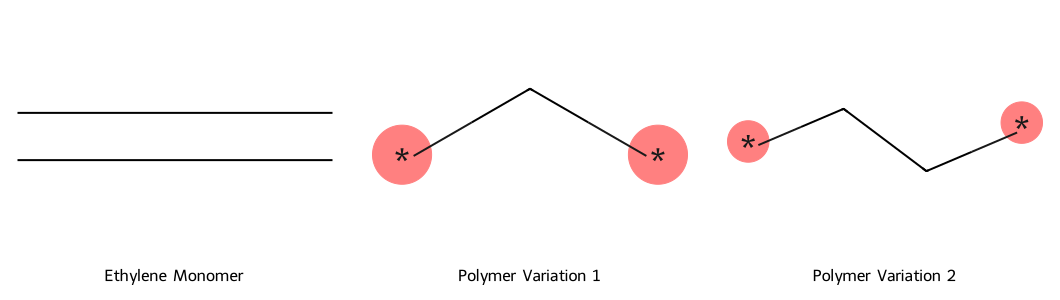

In [5]:
variations = get_variations([{"smiles":"C=C", "legend": "Ethylene Monomer", "ha": []},
      {"smiles": "[*]C[*]", "legend": "Polymer Variation 1", "ha": [0, 2]},
      {"smiles": "[*]CC[*]", "legend": "Polymer Variation 2", "ha": [0, 3]}])
show_images(variations)

The highlighted portions of the molecule indicate the open bond in the repeating unit. Similarly we can visualize different variations for Polyethylene Oxide (PEO) and Polypropylene (PP) in following manner.

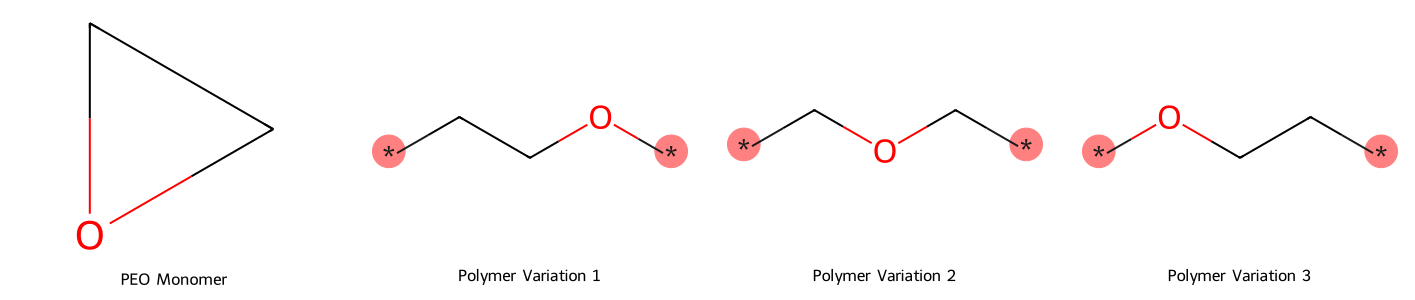

In [6]:
variations = get_variations([{"smiles":"C1CO1", "legend": "PEO Monomer", "ha": []},
      {"smiles": "[*]CCO[*]", "legend": "Polymer Variation 1", "ha": [0, 4]},
      {"smiles": "[*]COC[*]", "legend": "Polymer Variation 2", "ha": [0, 4]},
      {"smiles": "[*]OCC[*]", "legend": "Polymer Variation 3", "ha": [0, 4]}])
show_images(variations)

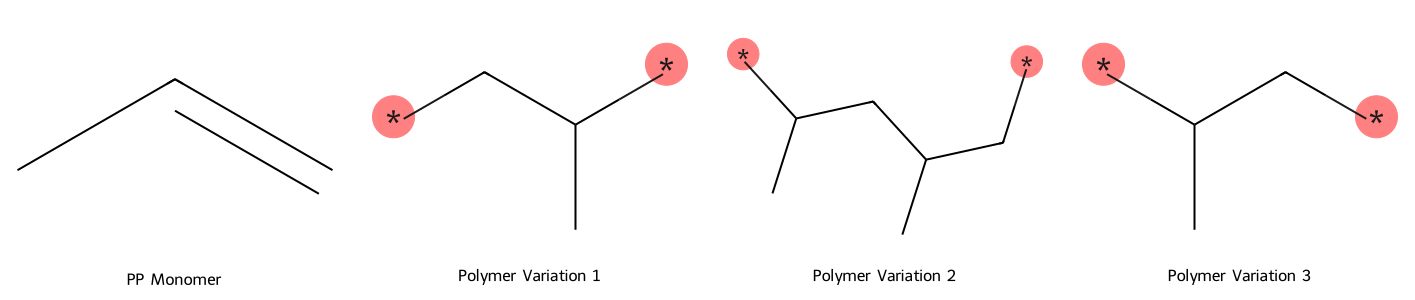

In [7]:
variations = get_variations([{"smiles":"CC=C", "legend": "PP Monomer", "ha": []},
      {"smiles": "[*]CC([*])C", "legend": "Polymer Variation 1", "ha": [0, 3]},
      {"smiles": "[*]CC(CC([*])C)C", "legend": "Polymer Variation 2", "ha": [0, 5]},
      {"smiles": "CC([*])C[*]", "legend": "Polymer Variation 3", "ha": [2, 4]}])
show_images(variations)

As per above descriptions, we can find various form of polymers from same monomer molecule. Hence we require a stadardized variation to be used for our applications. The canonicalization is the process of converting the monomer molecule into a standardized representation.

#### **Steps for Canonicalization** <a id="psmiles22"></a>

Following steps are followed to convert an arbitary polymer representation to a standard form for easier understanding and processibility. Along with the steps we are giving the examples of canonicalization of PEO.

1. Finding the shortest representation of a PSMILES string

  `[*]CCOCCO[*]` ->  `[*]CCO[*]`

2. Making the PSMILES string cyclic

  `[*]CCO[*]` -> `C1 CCO C1`

3. Applying the canonicalization routine as implemented in RDKit

  `C1 CCO C1` -> `C1 COC C1`

4. Breaking the cyclic bond

  `C1 COC C1` -> `[*]COC[*]`

In the first step redundant monomer representation is squeezed to smallest repeatable unit. For example the PEO representation can be given as `[*]CCOCCO[*]` while the `CCO` section is repeated. We can also see it visually.  

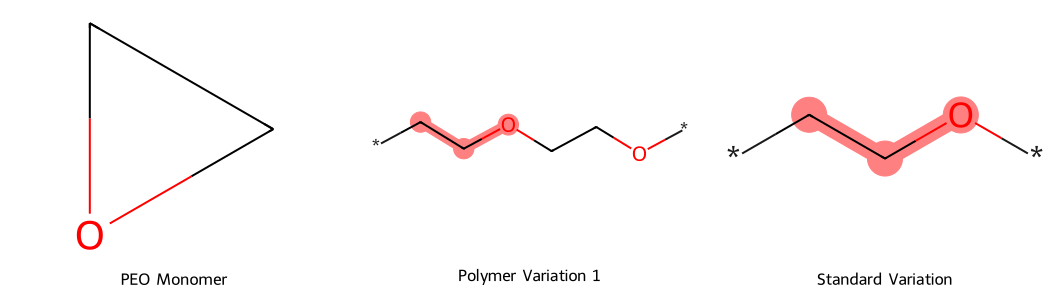

In [8]:
variations = get_variations([{"smiles":"C1CO1", "legend": "PEO Monomer", "ha": []},
      {"smiles": "[*]CCOCCO[*]", "legend": "Polymer Variation 1", "ha": [1, 2, 3]},
      {"smiles": "[*]CCO[*]", "legend": "Standard Variation", "ha": [1, 2, 3]}])
show_images(variations)

In the above image, we can see highlighted part in the polymer variation 1 is repeated. Hence only one repeating unit is kept in the standard variation.

The second step consists of replacing the wildcard `*` atom to a cyclic carbon atom, such that the resultant polymer representation could be a valid closed SMILES to follow the canonicalization process. Considering the example of PEO, we can visualize it as below.

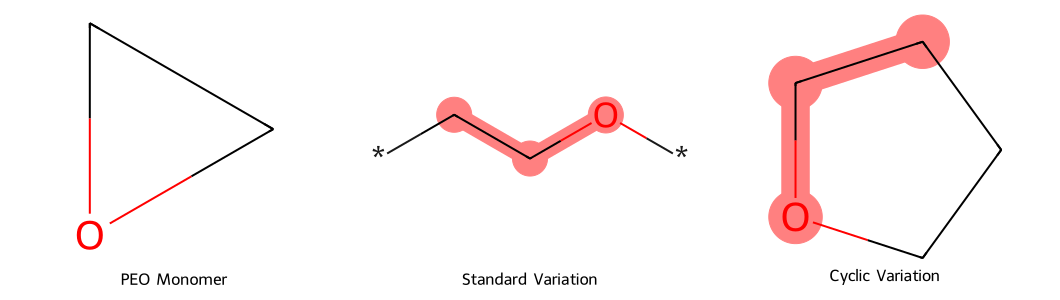

In [9]:
variations = get_variations([{"smiles":"C1CO1", "legend": "PEO Monomer", "ha": []},
      {"smiles": "[*]CCO[*]", "legend": "Standard Variation", "ha": [1, 2, 3]},
      {"smiles": "C1CCOC1", "legend": "Cyclic Variation", "ha": [1, 2, 3]}])
show_images(variations)

As the cyclic variation of the relevant molecule is formed, the modified representation can undergo standard canonicalization routine as implemented in [RDKit](https://www.rdkit.org/docs/RDKit_Book.html#searching-and-canonicalization). Using RDKit for canonicalization, we can index each atom in a definite order to impose normalization on every combination. In our case the converted variation will be something as follows.

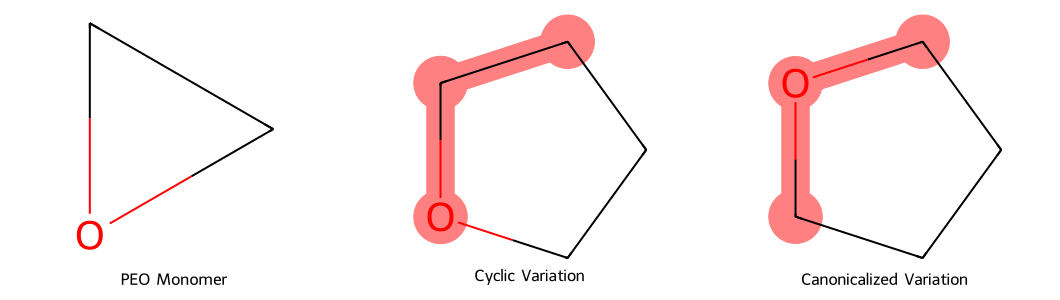

In [10]:
variations = get_variations([{"smiles":"C1CO1", "legend": "PEO Monomer", "ha": []},
      {"smiles": "C1CCOC1", "legend": "Cyclic Variation", "ha": [1, 2, 3]},
      {"smiles": "C1COCC1", "legend": "Canonicalized Variation", "ha": [1, 2, 3]},
                             ])
show_images(variations)

At the last step, the previously added carbon atoms to make the molecule cyclic will be removed. Hence making the final standardized form as follows.

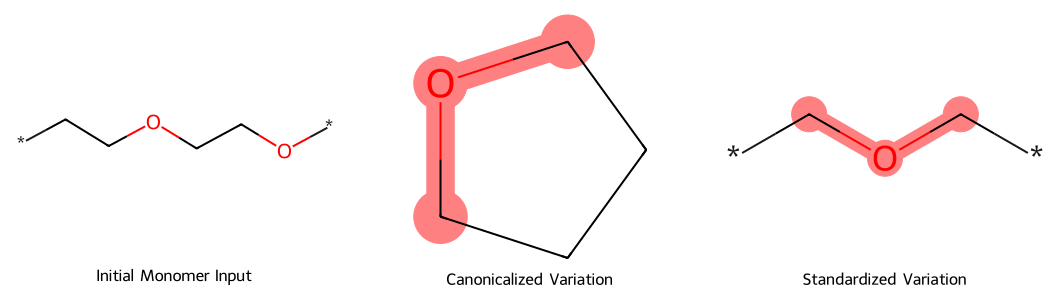

In [11]:
variations = get_variations([{"smiles":"[*]CCOCCO[*]", "legend": "Initial Monomer Input", "ha": []},
      {"smiles": "C1COCC1", "legend": "Canonicalized Variation", "ha": [1, 2, 3]},
      {"smiles": "[*]COC[*]", "legend": "Standardized Variation", "ha": [1, 2, 3]},
                             ])
show_images(variations)

In this manner we can convert different monomer inputs to a standardized variation. The singular reprsentation will facilitate more normalized study and easier understanding. The similar process for PP can be visualized as follows.

DEBUG:root:(1) Set labels and get connection dict 
 {'atom_rings': (),
 'bond_rings': (),
 'index': [0, 1, 2, 3, 4, 5, 6, 7],
 'neighbor': {'atom_type': [['C'], ['C']],
              'bond_type': [[rdkit.Chem.rdchem.BondType.SINGLE],
                            [rdkit.Chem.rdchem.BondType.SINGLE]],
              'index': [[1], [4]],
              'path': (1, 2, 3, 4)},
 'star': {'atom_type': ['*', '*'], 'bond_type': None, 'index': [0, 5]},
 'stereo': [],
 'symbols': ['*', 'C', 'C', 'C', 'C', '*', 'C', 'C']}


SMILES: *CC(C)CC(*)C |$;N1;;;;N2;;$,atomProp:0.dummyLabel.*:6.dummyLabel.*|


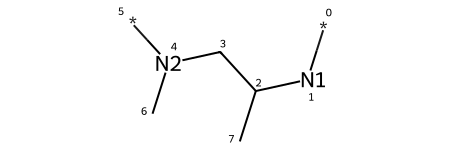

DEBUG:root:(2) Add bond between neighbors [[1], [4]]; bond type SINGLE SINGLE 


SMILES: *C1C(C)CC1(*)C |$;N1;;;;N2;;$,atomProp:0.dummyLabel.*:6.dummyLabel.*|


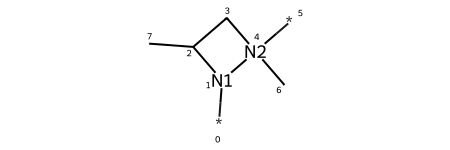

DEBUG:root:(3) Remove stars and bonds


SMILES: CC1CC(C)C1 |$;N2;N1;;;$|


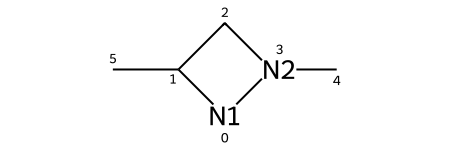

DEBUG:root:(4) Canonicalize


SMILES: CC1CC(C)C1 |$;N2;N1;;;$|


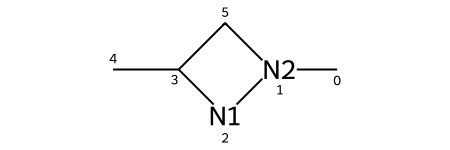

DEBUG:root:Found 1 rings that contain N1 and N2 and have length 4
DEBUG:root:Possible rings to break: [(1, 2, 3, 5)]
DEBUG:root:Searching in ring (sorted index): [1, 2, 3, 5]
DEBUG:root:Index 1 and 2 are in ring and connected with bond 5. Bond 5 is not in other rings. Break.
DEBUG:root:(5) Break bond at atom idx 1 and 2. Bond type was SINGLE


SMILES: CCCC(C)C |$;N2;;;N1;$|


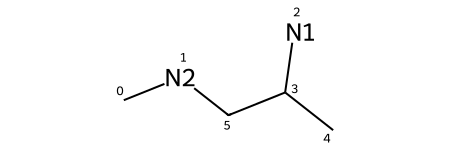

DEBUG:root:(6) Add stars at index 1 and 2 with bond type SINGLE. Renumber atoms.


SMILES: *CC(C)CC(*)C |atomProp:0.dummyLabel.*:6.dummyLabel.*|


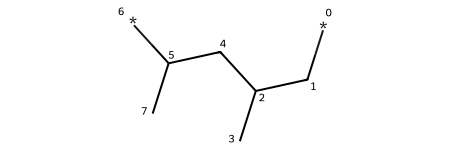

Canonicalized >> [*]CC(C)CC([*])C


In [12]:
# Set the logging level to DEBUG to get additional info
from canonicalize_psmiles.canonicalize import canonicalize
import logging
logging.getLogger().setLevel(logging.DEBUG)

smiles = "[*]CC(CC([*])C)C"
print("Canonicalized >>", canonicalize(smiles))

# The N1 and N2 referred below are not Nitrogen, rather a sign to denote the endpoint atom in the molecule, where the open bonds are connected.

For further information, refer to the [PSMILES guide](https://www.polymergenome.org/guide).

### 3. Tokenization of PSMILES with SentencePiece <a id="token"></a>

#### **Introduction to SentencePiece** <a id="token1"></a>

SentencePiece `[4]` is an unsupervised text tokenizer and detokenizer mainly used for Natural Language Processing (NLP) tasks. It can be particularly useful for tokenizing SMILES strings, which are sequences representing chemical structures, into smaller meaningful substructures.

By using SentencePiece, we can train a tokenizer specifically on SMILES strings, which will allow us to split them into meaningful tokens. Once tokenized, the SMILES strings can be converted into vector forms, which are essential for many machine learning tasks.

#### **Implementing SentencePiece** <a id="token2"></a>

The basic function of a tokenizer is to split the data into meaniful unique chunks such that a vector could be formed by converting unique chunks into a relevant numerical value. In our case the same could be achieved by using sentencePiece by following below steps.

1. Creating a sample text file containing SMILES value
2. Mentioning special chemical token / vocabulary to train on
3. Train the model by combining the data
4. Load and use the model to tokenize new data

The following code snippets does exactly the same.

In [13]:
# Step 1: Writing SMILES dataset to a text file
smiles_list = ["C1=CC=CC=C1", "CCO", "C(O)C", "[*]CC[*]",	"[*]COC[*]",	"[*]CC(CC([*])C)C", "[*]CCC[*]",	"[*]OCC[*]"	,"CC([*])C[*]"]  # Example SMILES
with open("smiles_data.txt", "w") as f:
    for smiles in smiles_list:
        f.write(smiles + "\n")

In [14]:
# Step 2:Mentioning special chemical token / vocabulary to train
special_tokens = [
    "[*]",
    "(", ")", "=", "@", "#",
    "0", "1", "2", "3", "4", "5", "6", "7", "8", "9",
    "-", "+",
    "/", "\\",
    "%", "[", "]",
] # special tokens that are used for bond and other chemical references

In [15]:
# Step 3: Train the model by combining the data
spm.SentencePieceTrainer.train(input='smiles_data.txt',
                               model_prefix='smiles_tokenizer',
                               vocab_size=30,
                               input_sentence_size=5_000_000,
                               character_coverage=1,
                               user_defined_symbols=special_tokens,
                               )

In [16]:
# Step 4: Use the model to tokenize new data

# Load the trained SentencePiece model
sp = spm.SentencePieceProcessor(model_file='smiles_tokenizer.model')

# Tokenize a sampel PP SMILES string
smiles = "[*]CC([*])C"
tokens = sp.encode(smiles, out_type=str)
print("Tokenized SMILES:", tokens)

Tokenized SMILES: ['▁', '[*]', 'C', 'C', '(', '[*]', ')', 'C']


In this manner we can tokenize a valid PSMILES into relevant tokens. Once tokenized, we can use [one-hot encoding](https://www.researchgate.net/publication/377159812_One-Hot_Encoding_and_Two-Hot_Encoding_An_Introduction) and other vectorization methods to generate relevant feature vectors.

### 4. Applications and Limitations <a id="app"></a>

PSMILES has been utilized in the development of the PolyBERT `[2]` model for multi-task property predictions. Its string structure is highly compatible with transformer models, creating opportunities to develop Polymer Language Models.

While PSMILES provides a useful way to represent polymer structures, there are some limitations:

1. **Complexity**: The notation can become unwieldy for large and complex polymers, especially those with multiple repeating units or irregular structures.
2. **Ambiguity**: PSMILES may not fully capture stereochemistry, which is important for the several properties of the polymer.
3. **Tool Support**: Not all cheminformatics tools support PSMILES, limiting its widespread adoption.

Despite these limitations, PSMILES remains a valuable tool in polymer science for representing and analyzing polymer structures computationally.

### 5. Summary <a id="sum"></a>

- **Introduction to PSMILES**

  - Polymer SMILES (PSMILES) is an extension of the SMILES notation, specifically developed to represent polymer structures. It allows for the representation of repeating units in polymers, facilitating their computational analysis and storage in databases.

- **PSMILES String Syntax and Canonicalization**

  - PSMILES strings use star symbols ([*]) to mark the endpoints of the polymer's repeating unit. The syntax can be ambiguous, with multiple valid representations for the same polymer. Canonicalization is essential to standardize these representations, ensuring consistent analysis. The process involves shortening the repeating unit, forming a cyclic representation, applying canonicalization using RDKit, and breaking the cyclic bond to obtain a standardized form.

- **Importance of Canonicalization**

  - Canonicalization is crucial for reducing ambiguity in PSMILES strings, ensuring that different representations of the same polymer are treated consistently. This process is necessary for accurate computational studies and comparisons between polymers.

- **Tokenization of PSMILES with SentencePiece**
  - SentencePiece is introduced as an unsupervised text tokenizer, useful for tokenizing SMILES strings into smaller, meaningful tokens. The steps involve preparing a dataset of SMILES strings, defining special chemical tokens, training the SentencePiece model, and using it to tokenize new SMILES strings. Tokenized SMILES strings can then be converted into vectors for use in machine learning models.

- **Applications and Limitations**
  - PSMILES has been employed in developing models like PolyBERT for multi-task property prediction. While the notation is highly compatible with transformer models, it has limitations such as complexity for large polymers, potential ambiguity in stereochemistry, and limited support from cheminformatics tools.

### 6. References <a id="ref"></a>
1. [Weininger, David. "SMILES, a chemical language and information system. 1. Introduction to methodology and encoding rules." Journal of chemical information and computer sciences 28.1 (1988): 31-36.](https://pubs.acs.org/doi/pdf/10.1021/ci00057a005)
2. [Kuenneth, Christopher, and Rampi Ramprasad. "polyBERT: a chemical language model to enable fully machine-driven ultrafast polymer informatics." Nature Communications 14.1 (2023): 4099.](https://www.nature.com/articles/s41467-023-39868-6)
3. https://github.com/Ramprasad-Group/canonicalize_psmiles
4. [Kudo, Taku, and John Richardson. "Sentencepiece: A simple and language independent subword tokenizer and detokenizer for neural text processing." arXiv preprint arXiv:1808.06226 (2018).](https://arxiv.org/abs/1808.06226)

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

## Citing This Tutorial
If you found this tutorial useful please consider citing it using the provided BibTeX.

In [ ]:
@manual{Intro1,
 title={Introduction to Polymer SMILES (PSMILES): Formation and Tokenization of Polymer String Representation},
 organization={DeepChem},
 author={Mohanty, Debasish},
 howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Introduction_to_Polymer_SMILES_(PSMILES).ipynb}},
 year={2024},
}